In [2]:
### Proyecto: Clasificación de Sesiones de Compra en E-commerce
### Modelo: Ensemble (VotingClassifier con CatBoost, XGBoost y RandomForest con Optuna)

# ----------------------------
# 1. CARGA DE LIBRERÍAS
# ----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import optuna
import warnings
warnings.filterwarnings('ignore')

# ----------------------------
# 2. CARGA DEL DATASET
# ----------------------------
df = pd.read_csv("data/online_shoppers_intention.csv")

# ----------------------------
# 3. PREPROCESAMIENTO Y NUEVAS FEATURES
# ----------------------------
from sklearn.preprocessing import LabelEncoder

df_processed = df.copy()

# 1. Codificar booleanas
df_processed['Revenue'] = df_processed['Revenue'].astype(int)
df_processed['Weekend'] = df_processed['Weekend'].astype(int)

# 2. One-hot encoding para nominales
df_processed = pd.get_dummies(df_processed, columns=['Month', 'VisitorType'], drop_first=True)

# 3. Label Encoding o dejar como está si son enteros ya
# En este caso, ya están como enteros: OperatingSystems, Browser, Region, TrafficType
df['Revenue'] = df['Revenue'].astype(int)
df['Weekend'] = df['Weekend'].astype(int)
df['ProductEffort'] = df['ProductRelated'] * df['ProductRelated_Duration']
df['BounceExitRatio'] = df['BounceRates'] / (df['ExitRates'] + 1e-6)
df_encoded = pd.get_dummies(df, columns=['Month', 'VisitorType'], drop_first=True)
X = df_encoded.drop('Revenue', axis=1)
y = df_encoded['Revenue']


# ----------------------------
# 4. SPLIT: TRAIN / VALID / TEST
# ----------------------------
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

In [3]:
# ----------------------------
# 5. OPTIMIZACIÓN CON OPTUNA PARA CATBOOST, XGBOOST Y RANDOMFOREST
# ----------------------------
def objective(trial):
    cat_params = {
        'iterations': trial.suggest_int('cat_iterations', 100, 300),
        'learning_rate': trial.suggest_float('cat_lr', 0.01, 0.2),
        'depth': trial.suggest_int('cat_depth', 4, 10),
        'verbose': 0,
        'random_state': 42
    }
    xgb_params = {
        'n_estimators': trial.suggest_int('xgb_n_estimators', 100, 300),
        'learning_rate': trial.suggest_float('xgb_lr', 0.01, 0.2),
        'max_depth': trial.suggest_int('xgb_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),  # L1
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),  # L2
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': 42
    }
    rf_params = {
        'n_estimators': trial.suggest_int('rf_n_estimators', 100, 300),
        'max_depth': trial.suggest_int('rf_depth', 5, 15),
        'random_state': 42
    }

    cat_model = CatBoostClassifier(**cat_params)
    xgb_model = XGBClassifier(**xgb_params)
    rf_model = RandomForestClassifier(**rf_params)

    voting_clf = VotingClassifier(
        estimators=[
            ('cat', cat_model),
            ('xgb', xgb_model),
            ('rf', rf_model)
        ],
        voting='soft'
    )

    voting_clf.fit(X_train, y_train)
    preds = voting_clf.predict(X_val)
    report = classification_report(y_val, preds, output_dict=True)
    return report['1']['f1-score']

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("\nMejores hiperparámetros del ensemble:")
print(study.best_params)


[I 2025-06-17 07:10:02,427] A new study created in memory with name: no-name-e4942c68-c376-45c6-8ae7-8563d06a2a82
[I 2025-06-17 07:10:04,525] Trial 0 finished with value: 0.6737588652482269 and parameters: {'cat_iterations': 174, 'cat_lr': 0.10916215125294056, 'cat_depth': 8, 'xgb_n_estimators': 252, 'xgb_lr': 0.18035573301666666, 'xgb_depth': 8, 'min_child_weight': 6, 'subsample': 0.934892354000977, 'colsample_bytree': 0.7958472632876613, 'reg_alpha': 0.5036060356369039, 'reg_lambda': 0.6586695992490242, 'rf_n_estimators': 166, 'rf_depth': 13}. Best is trial 0 with value: 0.6737588652482269.
[I 2025-06-17 07:10:06,095] Trial 1 finished with value: 0.6701940035273368 and parameters: {'cat_iterations': 146, 'cat_lr': 0.13608375149143723, 'cat_depth': 7, 'xgb_n_estimators': 238, 'xgb_lr': 0.10857599634184552, 'xgb_depth': 7, 'min_child_weight': 8, 'subsample': 0.8511567003717848, 'colsample_bytree': 0.9610878174829737, 'reg_alpha': 0.48722291403585427, 'reg_lambda': 0.17348635911499388, 


Mejores hiperparámetros del ensemble:
{'cat_iterations': 220, 'cat_lr': 0.08180832437018926, 'cat_depth': 6, 'xgb_n_estimators': 156, 'xgb_lr': 0.06331752380658791, 'xgb_depth': 9, 'min_child_weight': 2, 'subsample': 0.7411978465968966, 'colsample_bytree': 0.859398684979518, 'reg_alpha': 0.8445474397110279, 'reg_lambda': 0.4732885585114716, 'rf_n_estimators': 209, 'rf_depth': 15}


In [4]:
# ----------------------------
# 6. ENTRENAMIENTO FINAL CON LOS MEJORES PARÁMETROS
# ----------------------------
bp = study.best_params
cat_model = CatBoostClassifier(iterations=bp['cat_iterations'], learning_rate=bp['cat_lr'], depth=bp['cat_depth'], verbose=0, random_state=42)
xgb_model = XGBClassifier(n_estimators=bp['xgb_n_estimators'], learning_rate=bp['xgb_lr'], max_depth=bp['xgb_depth'], use_label_encoder=False, eval_metric='logloss', random_state=42)
rf_model = RandomForestClassifier(n_estimators=bp['rf_n_estimators'], max_depth=bp['rf_depth'], random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('cat', cat_model),
        ('xgb', xgb_model),
        ('rf', rf_model)
    ],
    voting='soft'
)
voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('cat',
                              <catboost.core.CatBoostClassifier object at 0x797714132680>),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None,
                                            feature_weights=Non...
                                            learning_rate=0.06331752380658791,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=9,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=156, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('rf',
                              RandomForestClassifier(max_depth=15,
                                                     n_estimators=209,
                                                     random_state=42))],
                 voting='soft')

In [5]:
# ----------------------------
# 7. EVALUACIÓN DEL ENSEMBLE EN VALID Y TEST
# ----------------------------
y_val_pred = voting_clf.predict(X_val)
y_test_pred = voting_clf.predict(X_test)

val_report = classification_report(y_val, y_val_pred, output_dict=True)
val_df = pd.DataFrame(val_report).transpose()
test_report = classification_report(y_test, y_test_pred, output_dict=True)
test_df = pd.DataFrame(test_report).transpose()

print("\nValidation Report:")
print(val_df.round(2))
print("Validation Accuracy:", val_report['accuracy'])
print("Validation AUC:", roc_auc_score(y_val, voting_clf.predict_proba(X_val)[:, 1]))

print("\nTest Report:")
print(test_df.round(2))
print("Test Accuracy:", test_report['accuracy'])
print("Test AUC:", roc_auc_score(y_test, voting_clf.predict_proba(X_test)[:, 1]))


Validation Report:
              precision  recall  f1-score  support
0                  0.93    0.96      0.95  1668.00
1                  0.73    0.63      0.67   305.00
accuracy           0.91    0.91      0.91     0.91
macro avg          0.83    0.79      0.81  1973.00
weighted avg       0.90    0.91      0.90  1973.00
Validation Accuracy: 0.9067410035478966
Validation AUC: 0.9338679875771514

Test Report:
              precision  recall  f1-score  support
0                  0.93    0.96      0.94   2084.0
1                  0.74    0.58      0.65    382.0
accuracy           0.90    0.90      0.90      0.9
macro avg          0.83    0.77      0.80   2466.0
weighted avg       0.90    0.90      0.90   2466.0
Test Accuracy: 0.902676399026764
Test AUC: 0.927912492086302


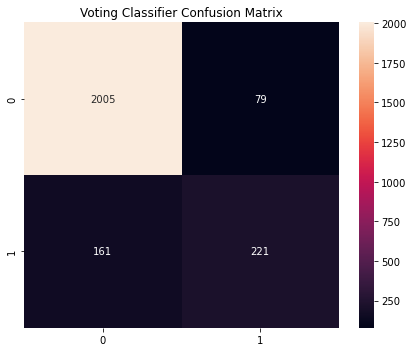

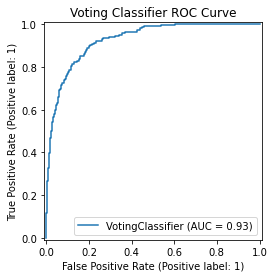

In [6]:

# ----------------------------
# 8. MATRIZ DE CONFUSIÓN Y CURVA ROC
# ----------------------------
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', ax=ax)
ax.set_title("Voting Classifier Confusion Matrix")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_estimator(voting_clf, X_test, y_test)
plt.title("Voting Classifier ROC Curve")
plt.show()


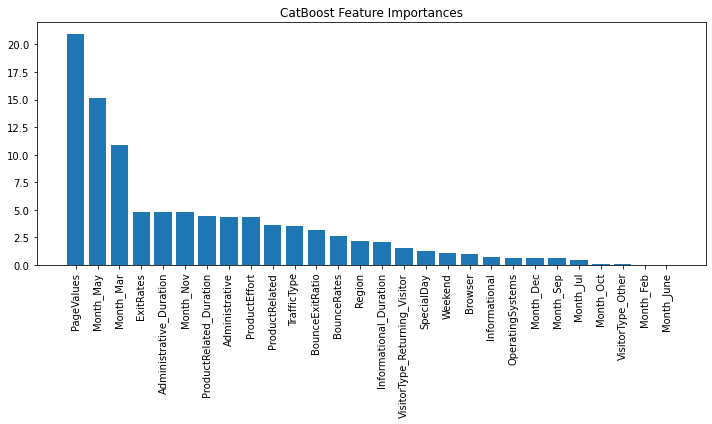

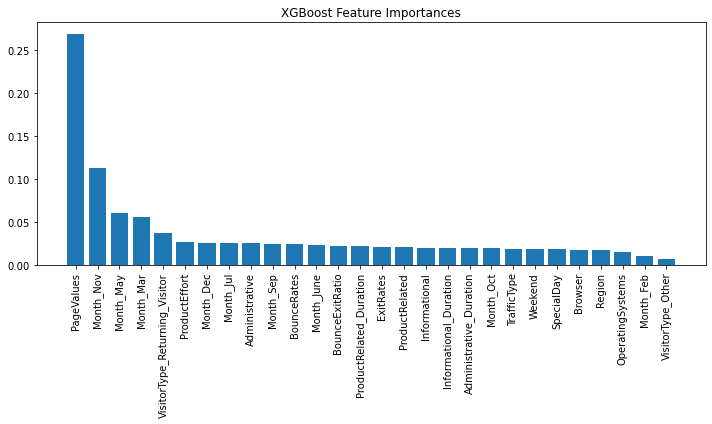

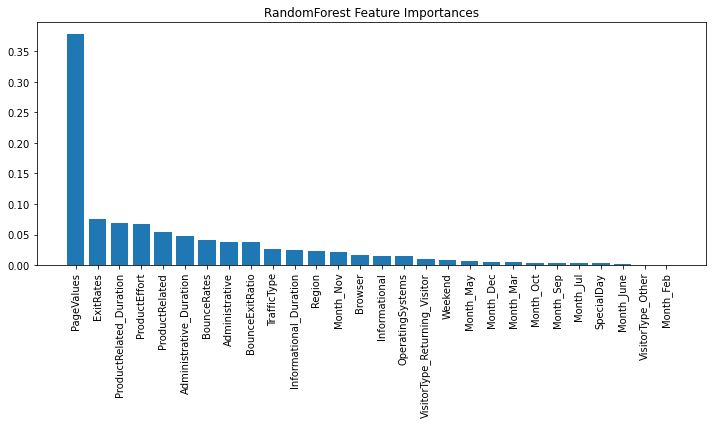

In [7]:
import matplotlib.pyplot as plt

import numpy as np

# Entrenar individualmente para poder acceder a .feature_importances_
cat_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
# ----------------------------
# 9. IMPORTANCIA DE FEATURES
# ----------------------------
# Función para graficar las características más importantes
def plot_feature_importances(model, feature_names, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()
# Graficar importancias de características para cada modelo
plot_feature_importances(cat_model, X_train.columns, "CatBoost Feature Importances")
plot_feature_importances(xgb_model, X_train.columns, "XGBoost Feature Importances")
plot_feature_importances(rf_model, X_train.columns, "RandomForest Feature Importances")


In [11]:
def evaluate_model_full(name, model, X_train, y_train, X_val, y_val):
    results = {'Modelo': name}

    for split, X, y in [('Train', X_train, y_train), ('Test', X_val, y_val)]:
        preds = model.predict(X)
        probas = model.predict_proba(X)[:, 1]
        report = classification_report(y, preds, output_dict=True)
        auc = roc_auc_score(y, probas)

        results[f'{split} Accuracy'] = report['accuracy']
        results[f'{split} F1-score (1)'] = report['1']['f1-score']
        results[f'{split} Precision (1)'] = report['1']['precision']
        results[f'{split} Recall (1)'] = report['1']['recall']
        results[f'{split} AUC'] = auc

    return results

voting_results = evaluate_model_full('VotingClassifier', voting_clf, X_train, y_train, X_val, y_val)




In [ ]:
# Crear DataFrame completo  los resultados
results_df = pd.DataFrame([voting_results])
results_df = results_df.set_index('Modelo')

# Filtrar columnas de entrenamiento y prueba
train_metrics = results_df[[col for col in results_df.columns if col.startswith('Train')]]
test_metrics = results_df[[col for col in results_df.columns if col.startswith('Test')]]

# Mostrar las dos tablas
print("🔹 Métricas en TRAIN:")
display(train_metrics.round(3))

print("\n🔸 Métricas en TEST:")
display(test_metrics.round(3))


🔹 Métricas en TRAIN:


,Train Accuracy,Train F1-score (1),Train Precision (1),Train Recall (1),Train AUC
Modelo,,,,,
VotingClassifier,0.979,0.93,0.985,0.88,0.998



🔸 Métricas en TEST:


,Test Accuracy,Test F1-score (1),Test Precision (1),Test Recall (1),Test AUC
Modelo,,,,,
VotingClassifier,0.907,0.675,0.732,0.626,0.934


Este modelo de ensamble, si bien obtiene algunas métricas por debajo de el modelo con Catboost, presenta mayor robustez, reflejado en un menor overfitting y un mayor área debajo de la curva (AUC), lo que justifica la decisión por este modelo.